<a href="https://colab.research.google.com/github/HarlinLee/cogsci-missed-connections/blob/main/abstract_content_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

import gensim
from gensim.utils import simple_preprocess

In [2]:
from google.colab import drive

drive.mount('/content/drive') 
DRIVE_PATH = "/content/drive/My Drive/REU evolution of scientific fields"

Mounted at /content/drive


In [3]:
# download required packages for 
import nltk

from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

# Load and Clean Abstracts

In [4]:
with open(os.path.join(DRIVE_PATH, 'filtered_new_fields_df.pkl'), 'rb') as file:
  fields_df = pickle.load(file)
print(fields_df.shape)

(59384, 18)


## Lemmatize abstracts


In [5]:
#A function to lemmatize words in a group of text 

lemmatizer = WordNetLemmatizer()

# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))

    return " ".join(lemmatized_sentence)

In [6]:
## Lemmatize abstracts 
lemm_abstracts = [lemmatize_sentence(text) for text in fields_df.A] 
fields_df["LA"] = lemm_abstracts

## Data Cleaning and Stopwords

In [7]:
replaced = fields_df.LA.str.replace(r'\W*\d+\W+\d*\W*\d*|\d+', ' ', regex=True)
replaced = replaced.str.replace(r'[^\x00-\x7F]+', ' ', regex=True)

In [8]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [9]:
data = replaced.str.lower().values.tolist()
data_words = list(sent_to_words(data))

In [10]:
stopwords_list = stopwords.words('english')
stopwords_list.extend(['et', 'al', 'et_al',
                       'research', 'theory', 'concept', 'field', 'study', 'chapter', 'approach', 'new', 'this_paper',
                       'use', 'argue', 'claim', 'argue_that', 'claim_that', 'explain', 'base_on',
                       'paper', 'article', 'present',
                       'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten'
                       ])

##Phrase Modeling: Bigram and Trigram Models

In [14]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=20, threshold=10) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], min_count=20, threshold=10)
print(len(bigram.vocab))
print(len(trigram.vocab))

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
print(len(trigram_mod.phrasegrams))

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


1539348
1661152
5741


In [15]:
# Define functions for bigrams and trigrams
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [16]:
data_words_trigrams = make_trigrams(data_words)
transformed_text = [' '.join(doc) for doc in data_words_trigrams]

## TF-IDF Bag of words

In [17]:
vectorizer = TfidfVectorizer(stop_words = stopwords_list,
                             max_df = 0.80, #remove words that appear in more than x% of documents
                             min_df = 0.0005, #remove words that appear in less than x% of documents
                             )
vectors = vectorizer.fit_transform(transformed_text).transpose()
print(vectors.shape)
idx_to_word = np.array(vectorizer.get_feature_names()) #dictionary to recover topics

(9106, 59384)


#Hierarchical NMF on Transformed Data

## NMF level 1

In [18]:
num_topics = 15
nmf0 = NMF(n_components=num_topics, 
           init='random', 
           random_state=2021, 
           max_iter=500, 
           tol=1e-5, 
           alpha=0.01)
W0 = nmf0.fit_transform(vectors)
H0 = nmf0.components_

for i, topic in enumerate(W0.transpose()):
    print("Topic {}: {}\n".format(i,", ".join(reversed(idx_to_word[topic.argsort()[-30:].astype(int)]))))

Topic 0: language, linguistic, communication, word, processing, evolution, meaning, speech, language_acquisition, linguistics, child, human, structure, semantic, acquisition, syntax, thought, grammar, production, hypothesis, metaphor, semantics, sign, evidence, communicative, aspect, syntactic, second, natural_language, emergence

Topic 1: development, science, review, biological, problem, provide, cell, many, behavior, evolution, discuss, question, mechanism, may, work, analysis, change, developmental, evolutionary, process, biology, function, different, method, make, scientific, issue, phenomenon, also, theoretical

Topic 2: action, agent, motor, perception, movement, goal, control, intention, belief, body, self, act, others, event, imitation, world, logic, mirror_neuron, sensorimotor, embodied, perform, simulation, environment, plan, execution, dynamic, activity, affordances, interaction, propose

Topic 3: human, social, behavior, animal, robot, communication, intelligence, agent, i

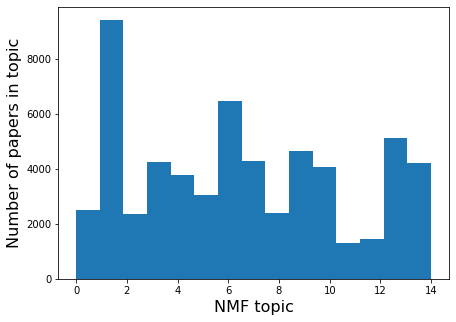

In [22]:
NMF_cluster = H0.argmax(axis=0)
plt.figure(figsize=(7,5))
plt.hist(NMF_cluster,bins=num_topics)
plt.xlabel('NMF topic', fontsize=16)
plt.ylabel('Number of papers in topic', fontsize=16)
plt.show()

In [23]:
supertopics_dict = dict(zip(fields_df.Id,NMF_cluster))
supertopic_to_keyword = {i:list(idx_to_word[topic.argsort()[:-6:-1].astype(int)]) for i, topic in enumerate(W0.T)}
id_to_topicword = {id:supertopic_to_keyword[supertopics_dict[id]] for id in fields_df.Id}

In [24]:
{i:", ".join(idx_to_word[topic.argsort()[:-6:-1].astype(int)]) for i, topic in enumerate(W0.T)}

{0: 'language, linguistic, communication, word, processing',
 1: 'development, science, review, biological, problem',
 2: 'action, agent, motor, perception, movement',
 3: 'human, social, behavior, animal, robot',
 4: 'learning, learn, knowledge, student, learner',
 5: 'memory, work, retrieval, information, event',
 6: 'visual, object, representation, information, spatial',
 7: 'system, complex, information, biological, dynamic',
 8: 'consciousness, conscious, mind, self, experience',
 9: 'model, propose, agent, describe, based',
 10: 'design, creativity, metaphor, creative, game',
 11: 'music, musical, sound, perception, performance',
 12: 'emotion, emotional, agent, affective, affect',
 13: 'cognitive, cognition, process, mind, cognitive_science',
 14: 'brain, network, function, neuroscience, neural'}

## NMF level 2

In [29]:
def run_level2_nmf(n_subtopics, topic_id, NMF_cluster):
  nmf = NMF(n_components=n_subtopics, init='random', random_state=0)

  subset = vectors[:, NMF_cluster==topic_id]
  print(subset.shape)
  W = nmf.fit_transform(subset)
  H = nmf.components_

  for i, topic in enumerate(W.transpose()):
    print("Topic {}: {}\n".format(i,", ".join(reversed(idx_to_word[topic.argsort()[-30:].astype(int)]))))
  
  return W, H

def update_subtopics_dict(topic_id, W, sub_NMF_cluster, fields_df, NMF_cluster, idx_to_word):
  subtopics_dict0 = dict(zip(fields_df.Id[NMF_cluster==topic_id], sub_NMF_cluster))
  subtopic_to_keyword0 = {i:list(idx_to_word[topic.argsort()[:-6:-1].astype(int)]) for i, topic in enumerate(W.T)}
  id_to_subtopicword0 = {id:subtopic_to_keyword0[subtopics_dict0[id]] for id in fields_df.Id[NMF_cluster==topic_id]}
  
  subtopics_dict.update(subtopics_dict0)
  id_to_subtopicword.update(id_to_subtopicword0)


In [30]:
subtopics_dict = {}
id_to_subtopicword = {}

ns = [10, 10, 8, 8, 4, 10, 10, 10, 10, 10, 8, 10, 10, 10, 10]
for id, n in enumerate(ns):
  print('====')
  print('topic id', id)
  W, H = run_level2_nmf(n, id, NMF_cluster)
  sub_NMF_cluster = H.argmax(axis=0)
  update_subtopics_dict(id, W, sub_NMF_cluster, fields_df, NMF_cluster, idx_to_word)
  

====
topic id 0
(9106, 2502)
Topic 0: language, brain, human, cognition, system, cognitive, learning, development, model, function, social, aspect, learn, understand, process, action, role, sign, way, play, show, understanding, influence, describe, spatial, universal, change, behavior, acquire, consider

Topic 1: meaning, word, semantic, language, mean, agent, form, semantics, sentence, structure, game, expression, symbolic, model, show, world, compositional, term, context, utterance, conceptual, call, embodied, account, construction, express, describe, ground, provide, system

Topic 2: processing, language, production, comprehension, network, region, syntactic, process, brain, sentence, area, phonological, aphasia, function, evidence, syntax, involve, language_comprehension, structure, neural, support, model, left, mechanism, review, may, broca, functional, system, level

Topic 3: evolution, language, human, evolutionary, evolve, origin, emergence, capacity, cultural_evolution, hypoth

In [31]:
topics_df = pd.DataFrame.from_dict(supertopics_dict,orient='index',columns=['SupertopicId'])
topics_df['SubtopicId'] = topics_df.index.map(subtopics_dict)
topics_df['SupertopicKeywords'] = topics_df.index.map(id_to_topicword)
topics_df['SubtopicKeywords'] = topics_df.index.map(id_to_subtopicword)

topics_df['Super3'] = topics_df['SupertopicKeywords'].apply(lambda x: ', '.join(x[:3]))
topics_df['Sub3'] = topics_df['SubtopicKeywords'].apply(lambda x: ', '.join(x[:3]))

In [32]:
# save
with open(os.path.join(DRIVE_PATH,'topics_df_new.pkl'),'wb') as f:
    pickle.dump(topics_df,f)